# ICC305 Avaliação de Desempenho - 2023/1

## Atividade 3

**Giovanna** Andrade Santos - 22052563

**Marcos** Avner Pimenta de Lima - 21852448

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import math
import time

from scipy.stats import chisquare
from scipy.stats import chi2_contingency

from ad_library import myfunctions
from collections import defaultdict

## Parte 1 - MM1

In [3]:
#nº de clientes
n1 = 10 ** 3
n2 = 10 ** 6
n3 = 10 ** 9
n4 = 10 ** 12

#taxa de entrada --> 9 clientes/s
tc = 9

#taxa de serviço --> 10 clientes/s
ts = 10

In [4]:

def mm1(n=1000, tc=9., ts=10., gerador=myfunctions.G5RandomGenerator()):
    lamb = 1. / tc
    mu = 1. / ts
    fila = list() # fila de espera
    # espera = np.zeros(n)
    # o vetor de tempos de espera irá armazenar valores em milisegundos (inteiros)
    # isso é para economizar memória RAM
    espera = np.zeros(n, dtype='uint16')
    cont = 0
    
    prox_chegada = myfunctions.va_exp(lamb, gerador) # computa o tempo da proxima chegada.
    prox_atend = prox_chegada + myfunctions.va_exp(mu, gerador) # computa o tempo da conclusao do proximo atendimento.
    
    # inicia a simulação da fila MM1.
    while n > 0:

        while prox_chegada < prox_atend:
            # simula a proxima chegada
            fila.append(prox_chegada)
            prox_chegada += myfunctions.va_exp(lamb, gerador)

        # Next event is a service completion.
        if fila:
            chegada = fila.pop(0)
            # para redução do consumo de RAM os tempos de espera são convertidos para milisegundos (inteiros)
            e = int((prox_atend - chegada) * 1000)
            espera[cont] = e if e > 0 else 0
            # espera[cont] = prox_atend - chegada
            cont += 1

        # atualiza a fila de espera.
        if fila:
            # se a fila não estiver vazia, o termino do proximo atendimento 
            # é incrementando com o ts
            prox_atend += myfunctions.va_exp(mu, gerador)
        else:
            # se a fila estiver vazia, o termino do próximo atendimento
            # é incrementando com o (tc + ts)
            prox_atend = prox_chegada + myfunctions.va_exp(mu, gerador)
        
        n -= 1
    return espera

In [5]:
#função para calcular intervalo de confiança
def ic(n, media, values: list, alpha=.05):
    std = np.std(values)
    H = st.t.ppf(q=1. - alpha / 2., df=n-1) * std
    li = media - H
    ls = media + H
    return (li, ls)

In [18]:
g5 = myfunctions.G5RandomGenerator()
g5.reset() # reinicia o gerador com a seed para replicação de resultados

for n in [n1, n2, n3]:    
    print(f'Iniciando simulação para n={n}')
    start = time.time()
    tot_espera = mm1(n, tc, ts, g5)
    end = time.time()
    print(f'Fim da simulação!')
    print(f'Tempo: {end-start} ms')
    
    print('Salvando tempos de espera')
    with open(f'mm1_n{n}', 'wb') as f:
        np.save(f, tot_espera)
        
    print('Calculando intervalo de confiança')
    soma = np.sum(tot_espera)
    media = myfunctions.mean(tot_espera)
    inter_conf = ic(n, media, tot_espera)
    
    print(f'N: {n}')
    print(f'Espera total: {soma} ms')
    print(f'Espera Média: {media} ms')
    print(f'Espera IC: {inter_conf} ms')
    print()

Iniciando simulação para n=1000
Fim da simulação!
Tempo: 0.055075883865356445ms
Salvando tempos de espera
Calculando intervalo de confiança
N: 1000
Espera total: 673838 ms
Espera Média: 673.838 ms
Espera IC: (-396.5929554419736, 1744.2689554419735) ms

Iniciando simulação para n=1000000
Fim da simulação!
Tempo: 0.9812638759613037ms
Salvando tempos de espera
Calculando intervalo de confiança
N: 1000000
Espera total: 1003611329 ms
Espera Média: 1003.611329 ms
Espera IC: (-961.434759208849, 2968.657417208849) ms

Iniciando simulação para n=1000000000
Fim da simulação!
Tempo: 1006.5161719322205ms
Salvando tempos de espera
Calculando intervalo de confiança
N: 1000000000
Espera total: 1000629351149 ms
Espera Média: 1000.629351149 ms
Espera IC: (-964.2031208617949, 2965.4618231597947) ms



In [23]:
valor_esperado = myfunctions.valor_esperado(tc, ts)
print(f'O valor esperado do tempo de espera para os valores de lambda e mi é {valor_esperado:.5} segundos')

O valor esperado do tempo de espera para os valores de lambda e mi é 0.9 segundos


O valor médio esperado é de aproximadamente `0.9 segundos`.

Para `n=1000` o tempo médio $\overline{X}(n)$ foi de aproximadamente `0.673 segundos` bem longe do valor esperado, embora o intervalo de confiança `[-0.396, 1.733]`  contenha o valor esperado.

Para `n=1000000` o tempo médio $\overline{X}(n)$ foi de aproximadamente `1.003 segundos`, mais próximo do valor esperado, e o intervalo de confiança `[-0.961, 2.968]` também contem o valor esperado.

Para `n=1000000000` o tempo médio $\overline{X}(n)$ foi de aproximadamente `1.000 segundos`, um pouco mais próximo do valor esperado, e novamente intervalo de confiança `[-0.961, 2.968]` contem o valor esperado.

## Parte 2 - Chow e Robbins

In [6]:

def mm1_v2(d, batch=10, tc=9., ts=10., gerador=myfunctions.G5RandomGenerator()):
    lamb = 1. / tc
    mu = 1. / ts
    fila = list() # fila de espera
    H = 0
    n = 10
    
    # o vetor de tempos de espera irá armazenar valores em milisegundos (inteiros)
    # isso é para economizar memória RAM
    espera = np.zeros(n)
    cont = 0   
    
    # inicia a simulação da fila MM1 (Chow e Robbins)
    while H <= d:

        prox_chegada = myfunctions.va_exp(lamb, gerador) # computa o tempo da proxima chegada.
        prox_atend = prox_chegada + myfunctions.va_exp(mu, gerador) # computa o tempo da conclusao do proximo atendimento.
        x = cont
        
        while x < n:
            while prox_chegada < prox_atend:
                # simula a proxima chegada
                fila.append(prox_chegada)
                prox_chegada += myfunctions.va_exp(lamb, gerador)

            # Next event is a service completion.
            if fila:
                chegada = fila.pop(0)
                e = prox_atend - chegada
                # esperas negativas, significam que a chega ocorre apos o termino do atendimento
                # logo não houve espera, por isso adotamos como zero
                espera[cont] = e if e > 0 else 0.
                # espera[cont] = prox_atend - chegada
                cont += 1

            # atualiza a fila de espera.
            if fila:
                # se a fila não estiver vazia, o termino do proximo atendimento 
                # é incrementando com o ts
                prox_atend += myfunctions.va_exp(mu, gerador)
            else:
                # se a fila estiver vazia, o termino do próximo atendimento
                # é incrementando com o (tc + ts)
                prox_atend = prox_chegada + myfunctions.va_exp(mu, gerador)
            x += 1
        
        std = myfunctions.std(espera)
        H = st.t.ppf(q=1. - .05 / 2., df=n-1) * std
        print(f'H={H}, n={n}')
        n += batch
        espera = np.resize(espera, (n, ))
        
    return (n, espera)

### d = 0.1

In [28]:
g5 = myfunctions.G5RandomGenerator()
g5.reset() # reinicia o gerador com a seed para replicação de resultados

n = mm1_v2(.1, 1, tc, ts, g5)
n

H=0.24335601759919445, n=10


(11,
 array([0.14186292, 0.13313644, 0.13598471, 0.12117453, 0.08755856,
        0.07025651, 0.12980219, 0.02883574, 0.40620018, 0.25867514,
        0.14186292]))

In [31]:
data = []

for e in n[1]:
    data.append([e, 'd = 0.1'])

data

[[0.14186291529717618, 'd = 0.1'],
 [0.133136439968302, 'd = 0.1'],
 [0.13598471405610768, 'd = 0.1'],
 [0.12117453325953226, 'd = 0.1'],
 [0.0875585638878692, 'd = 0.1'],
 [0.07025651019193324, 'd = 0.1'],
 [0.12980218745975824, 'd = 0.1'],
 [0.02883574222657259, 'd = 0.1'],
 [0.406200183506618, 'd = 0.1'],
 [0.2586751398695186, 'd = 0.1'],
 [0.14186291529717618, 'd = 0.1']]

A amplitude `H` passou o valor `d=0.1` após `11 chegadas`.

### d = 0.5

In [32]:
g5 = myfunctions.G5RandomGenerator()
g5.reset() # reinicia o gerador com a seed para replicação de resultados

n = mm1_v2(.5, 6, tc, ts, g5)
n

H=0.24335601759919445, n=10
H=0.32207370965011173, n=16
H=0.32061494418403547, n=22
H=0.40527980698218863, n=28
H=0.45679722562734454, n=34
H=0.5646726431903302, n=40


(46,
 array([0.14186292, 0.13313644, 0.13598471, 0.12117453, 0.08755856,
        0.07025651, 0.12980219, 0.02883574, 0.40620018, 0.25867514,
        0.        , 0.15828147, 0.48642715, 0.45333034, 0.34548972,
        0.27488245, 0.        , 0.37640325, 0.27504252, 0.35873525,
        0.31039868, 0.44187876, 0.        , 0.        , 0.38791652,
        0.38683597, 0.70598148, 0.66554229, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.80322562, 0.11626046,
        0.18684899, 0.2655028 , 0.40714219, 0.68051691, 1.32520828,
        0.14186292, 0.13313644, 0.13598471, 0.12117453, 0.08755856,
        0.07025651]))

In [33]:
for e in n[1]:
    data.append([e, 'd = 0.5'])

data

[[0.14186291529717618, 'd = 0.1'],
 [0.133136439968302, 'd = 0.1'],
 [0.13598471405610768, 'd = 0.1'],
 [0.12117453325953226, 'd = 0.1'],
 [0.0875585638878692, 'd = 0.1'],
 [0.07025651019193324, 'd = 0.1'],
 [0.12980218745975824, 'd = 0.1'],
 [0.02883574222657259, 'd = 0.1'],
 [0.406200183506618, 'd = 0.1'],
 [0.2586751398695186, 'd = 0.1'],
 [0.14186291529717618, 'd = 0.1'],
 [0.14186291529717618, 'd = 0.5'],
 [0.133136439968302, 'd = 0.5'],
 [0.13598471405610768, 'd = 0.5'],
 [0.12117453325953226, 'd = 0.5'],
 [0.0875585638878692, 'd = 0.5'],
 [0.07025651019193324, 'd = 0.5'],
 [0.12980218745975824, 'd = 0.5'],
 [0.02883574222657259, 'd = 0.5'],
 [0.406200183506618, 'd = 0.5'],
 [0.2586751398695186, 'd = 0.5'],
 [0.0, 'd = 0.5'],
 [0.15828147470973886, 'd = 0.5'],
 [0.48642715300861694, 'd = 0.5'],
 [0.45333034140481254, 'd = 0.5'],
 [0.3454897161602169, 'd = 0.5'],
 [0.27488244810100926, 'd = 0.5'],
 [0.0, 'd = 0.5'],
 [0.3764032450955753, 'd = 0.5'],
 [0.2750425229873964, 'd = 0.5'

A amplitude `H` passou o valor `d=0.5` após `46 chegadas`. Demorando um pouco mais que o caso anterior.

### d = 1.0

In [34]:
g5 = myfunctions.G5RandomGenerator()
g5.reset() # reinicia o gerador com a seed para replicação de resultados

n = mm1_v2(1., 18, tc, ts, g5)
n

H=0.24335601759919445, n=10
H=0.28326933960590883, n=28
H=0.32277283147098357, n=46
H=0.4581184186165247, n=64
H=0.5341364666462284, n=82
H=0.6290122502193766, n=100
H=0.6880707872524778, n=118
H=0.6649893763292508, n=136
H=0.9575401444881178, n=154
H=0.9402159051293875, n=172
H=1.016100720272203, n=190


(208,
 array([0.14186292, 0.13313644, 0.13598471, 0.12117453, 0.08755856,
        0.07025651, 0.12980219, 0.02883574, 0.40620018, 0.25867514,
        0.        , 0.15828147, 0.48642715, 0.45333034, 0.34548972,
        0.27488245, 0.17932039, 0.2012262 , 0.14479979, 0.06803847,
        0.0279596 , 0.20438523, 0.3433716 , 0.30965373, 0.28774954,
        0.03857428, 0.27005855, 0.42568009, 0.        , 0.        ,
        0.        , 0.        , 0.18343556, 0.17752661, 0.14701002,
        0.23759923, 0.41194944, 0.48293286, 0.27528176, 0.04964233,
        0.03224587, 0.18936989, 0.08911133, 0.08667747, 0.57894653,
        0.5538756 , 0.        , 0.        , 0.        , 0.        ,
        0.43107722, 0.49363421, 0.58008947, 0.40693842, 0.49594244,
        0.56415087, 0.82505501, 0.577939  , 0.49799938, 0.71927017,
        0.69286072, 0.73186528, 0.7493187 , 0.45880827, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        

In [35]:
for e in n[1]:
    data.append([e, 'd = 1.0'])

data

[[0.14186291529717618, 'd = 0.1'],
 [0.133136439968302, 'd = 0.1'],
 [0.13598471405610768, 'd = 0.1'],
 [0.12117453325953226, 'd = 0.1'],
 [0.0875585638878692, 'd = 0.1'],
 [0.07025651019193324, 'd = 0.1'],
 [0.12980218745975824, 'd = 0.1'],
 [0.02883574222657259, 'd = 0.1'],
 [0.406200183506618, 'd = 0.1'],
 [0.2586751398695186, 'd = 0.1'],
 [0.14186291529717618, 'd = 0.1'],
 [0.14186291529717618, 'd = 0.5'],
 [0.133136439968302, 'd = 0.5'],
 [0.13598471405610768, 'd = 0.5'],
 [0.12117453325953226, 'd = 0.5'],
 [0.0875585638878692, 'd = 0.5'],
 [0.07025651019193324, 'd = 0.5'],
 [0.12980218745975824, 'd = 0.5'],
 [0.02883574222657259, 'd = 0.5'],
 [0.406200183506618, 'd = 0.5'],
 [0.2586751398695186, 'd = 0.5'],
 [0.0, 'd = 0.5'],
 [0.15828147470973886, 'd = 0.5'],
 [0.48642715300861694, 'd = 0.5'],
 [0.45333034140481254, 'd = 0.5'],
 [0.3454897161602169, 'd = 0.5'],
 [0.27488244810100926, 'd = 0.5'],
 [0.0, 'd = 0.5'],
 [0.3764032450955753, 'd = 0.5'],
 [0.2750425229873964, 'd = 0.5'

A amplitude `H` passou o valor `d=1.0` após `208 chegadas`. Demorando um pouco mais que o caso anterior.

### d = 2.0

In [36]:
g5 = myfunctions.G5RandomGenerator()
g5.reset() # reinicia o gerador com a seed para replicação de resultados

n = mm1_v2(2., 50, tc, ts, g5)
n

H=0.24335601759919445, n=10
H=0.3017319908664084, n=60
H=0.42576466982865663, n=110
H=1.493478244138093, n=160
H=2.5475362880061105, n=210


(260,
 array([1.41862915e-01, 1.33136440e-01, 1.35984714e-01, 1.21174533e-01,
        8.75585639e-02, 7.02565102e-02, 1.29802187e-01, 2.88357422e-02,
        4.06200184e-01, 2.58675140e-01, 0.00000000e+00, 1.58281475e-01,
        4.86427153e-01, 4.53330341e-01, 3.45489716e-01, 2.74882448e-01,
        1.79320391e-01, 2.01226196e-01, 1.44799790e-01, 6.80384701e-02,
        2.79596022e-02, 2.04385228e-01, 3.43371604e-01, 3.09653727e-01,
        2.87749541e-01, 3.85742785e-02, 2.70058549e-01, 4.25680086e-01,
        4.29072335e-01, 3.81420748e-01, 3.52204494e-01, 3.56560063e-01,
        4.85972286e-02, 3.42954505e-02, 1.05839931e-01, 1.47601950e-01,
        2.38191160e-01, 4.12541369e-01, 4.83524797e-01, 2.75873691e-01,
        4.96423255e-02, 3.22458657e-02, 1.89369894e-01, 8.91113319e-02,
        8.66774666e-02, 5.78946528e-01, 5.53875599e-01, 4.63891265e-01,
        3.01170797e-01, 3.16524407e-01, 4.00751649e-01, 3.00838496e-01,
        2.85725215e-01, 2.59253016e-01, 4.55146479e-01, 2.

A amplitude `H` passou o valor `d=2.0` após `260 chegadas`.

In [37]:
for e in n[1]:
    data.append([e, 'd = 2.0'])

data

[[0.14186291529717618, 'd = 0.1'],
 [0.133136439968302, 'd = 0.1'],
 [0.13598471405610768, 'd = 0.1'],
 [0.12117453325953226, 'd = 0.1'],
 [0.0875585638878692, 'd = 0.1'],
 [0.07025651019193324, 'd = 0.1'],
 [0.12980218745975824, 'd = 0.1'],
 [0.02883574222657259, 'd = 0.1'],
 [0.406200183506618, 'd = 0.1'],
 [0.2586751398695186, 'd = 0.1'],
 [0.14186291529717618, 'd = 0.1'],
 [0.14186291529717618, 'd = 0.5'],
 [0.133136439968302, 'd = 0.5'],
 [0.13598471405610768, 'd = 0.5'],
 [0.12117453325953226, 'd = 0.5'],
 [0.0875585638878692, 'd = 0.5'],
 [0.07025651019193324, 'd = 0.5'],
 [0.12980218745975824, 'd = 0.5'],
 [0.02883574222657259, 'd = 0.5'],
 [0.406200183506618, 'd = 0.5'],
 [0.2586751398695186, 'd = 0.5'],
 [0.0, 'd = 0.5'],
 [0.15828147470973886, 'd = 0.5'],
 [0.48642715300861694, 'd = 0.5'],
 [0.45333034140481254, 'd = 0.5'],
 [0.3454897161602169, 'd = 0.5'],
 [0.27488244810100926, 'd = 0.5'],
 [0.0, 'd = 0.5'],
 [0.3764032450955753, 'd = 0.5'],
 [0.2750425229873964, 'd = 0.5'

In [41]:
df_data = pd.DataFrame(data, columns=['espera', 'd'])

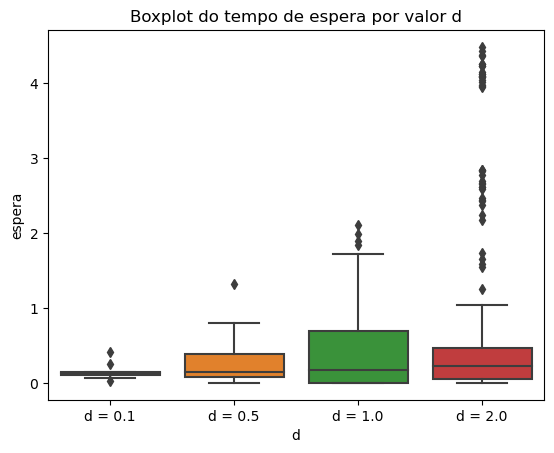

In [46]:
plt.title('Boxplot do tempo de espera por valor d')
sns.boxplot(df_data, x='d', y='espera')
plt.show()

Com os resultados obtidos temos que para intervalos de confiança temos que pada maiores valores de `d` é necessário uma amostra maior. 

## Parte 3

In [47]:

def mm1_v3(gamma, batch=10, tc=9., ts=10., gerador=myfunctions.G5RandomGenerator()):
    lamb = 1. / tc
    mu = 1. / ts
    fila = list() # fila de espera
    H = 0
    n = 10
    
    # o vetor de tempos de espera irá armazenar valores em milisegundos (inteiros)
    # isso é para economizar memória RAM
    espera = np.zeros(n)
    cont = 0
    xn = 0.0000000000000000000001
    
    # inicia a simulação da fila MM1 (Chow e Robbins)
    while H/xn <= gamma:

        prox_chegada = myfunctions.va_exp(lamb, gerador) # computa o tempo da proxima chegada.
        prox_atend = prox_chegada + myfunctions.va_exp(mu, gerador) # computa o tempo da conclusao do proximo atendimento.
        x = cont
        
        while x < n:
            while prox_chegada < prox_atend:
                # simula a proxima chegada
                fila.append(prox_chegada)
                prox_chegada += myfunctions.va_exp(lamb, gerador)

            # Next event is a service completion.
            if fila:
                chegada = fila.pop(0)
                e = prox_atend - chegada
                # esperas negativas, significam que a chega ocorre apos o termino do atendimento
                # logo não houve espera, por isso adotamos como zero
                espera[cont] = e if e > 0 else 0.
                # espera[cont] = prox_atend - chegada
                cont += 1

            # atualiza a fila de espera.
            if fila:
                # se a fila não estiver vazia, o termino do proximo atendimento 
                # é incrementando com o ts
                prox_atend += myfunctions.va_exp(mu, gerador)
            else:
                # se a fila estiver vazia, o termino do próximo atendimento
                # é incrementando com o (tc + ts)
                prox_atend = prox_chegada + myfunctions.va_exp(mu, gerador)
            x += 1
        
        xn = myfunctions.mean(espera)
        std = np.std(espera)
        H = st.t.ppf(q=1. - .05 / 2., df=n-1) * std
        print(f'H={H}, X(n)={xn}, n={n}')
        n += batch
        espera = np.resize(espera, (n, ))
        
    return (H, xn, n, espera)

In [48]:
g5 = myfunctions.G5RandomGenerator()
g5.reset() # reinicia o gerador com a seed para replicação de resultados

H, Xn, n, espera = mm1_v3(.05, 1, tc, ts, g5)

print(f'H = {H}')
print(f'Xn = {Xn}')
print(f'n = {n}')
print()

H=0.23086778937644267, X(n)=0.1513486929723388, n=10
H = 0.23086778937644267
Xn = 0.1513486929723388
n = 11



In [54]:
df_gamma = pd.DataFrame([(e,'0.05') for e in espera], columns=['espera', 'gamma'])
df_gamma

,espera,gamma
0,0.141863,0.05
1,0.133136,0.05
2,0.135985,0.05
3,0.121175,0.05
4,0.087559,0.05
5,0.070257,0.05
6,0.129802,0.05
7,0.028836,0.05
8,0.406200,0.05
9,0.258675,0.05


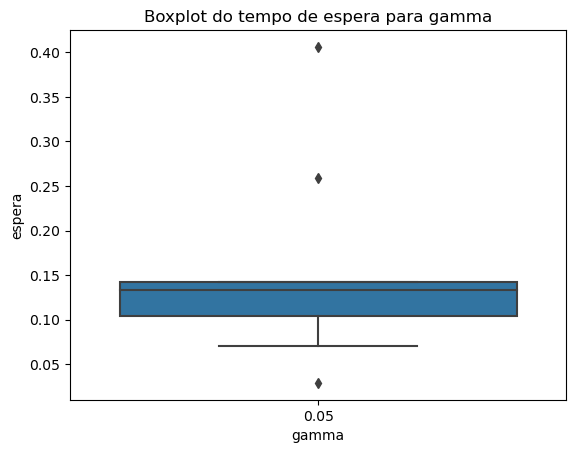

In [55]:
plt.title('Boxplot do tempo de espera para gamma')
sns.boxplot(df_gamma, x='gamma', y='espera')
plt.show()